# **1D Simulator**
This code is used to simulate 1D equations in order to create some data for ai training. 

The first part will be the reprodcution burger equation in 1D such as :
$$
\begin{equation}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
\end{equation}
$$

In [1]:
import os, random, collections.abc
import numpy as np
import matplotlib.pyplot as plt

# Physical Simulator

## 1D Grid creation helper

In [2]:
class Grid1D:
    def __init__(self, nb_points_x, x_min, x_max, t_max, dt):
        if x_max < x_min:
            x_min, x_max = x_max, x_min
        self.nb_points_x = int(nb_points_x)
        self.x_min, self.x_max = float(x_min), float(x_max)
        self.dt = float(dt)

        # temps
        self.nb_points_t = int(np.floor(t_max / dt)) + 1
        self.t_max = self.dt * (self.nb_points_t - 1)

        # espace
        self.dx = (self.x_max - self.x_min) / (self.nb_points_x - 1)
        self.x = np.linspace(self.x_min, self.x_max, self.nb_points_x)
        self.t = np.linspace(0, self.t_max, self.nb_points_t)

    def save_npz(self, path, U, *, nu=None, speed=None, tag=""):
        meta = dict(
            U=U.astype(np.float32),
            x=self.x.astype(np.float32),
            t=self.t.astype(np.float32),
            dx=np.float32(self.dx),
            dt=np.float32(self.dt),
        )
        if nu is not None:
            meta["nu"] = np.float32(nu)
        if speed is not None:
            meta["speed"] = np.float32(speed)
        if tag:
            meta["tag"] = np.str_(tag)
        folder = os.path.dirname(path)
        if folder:
            os.makedirs(folder, exist_ok=True)
        np.savez_compressed(path, **meta)

    # (Optionnel) petites aides pour viz rapide
    def plot(self, U, title="Burgers 1D", xlabel="X", ylabel="T", label=None, cmap='seismic'):
        plt.figure(figsize=(10, 6))
        plt.imshow(
            U,
            extent=[self.x.min(), self.x.max(), self.t.max(), self.t.min()],
            cmap=cmap, interpolation='nearest', aspect='auto', origin='upper'
        )
        plt.colorbar(label=label)
        plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.show()

    def plot_initial_condition(self, U, title="U(x, t=0)", label=None, cmap='seismic'):
        # accepte U 2D (t,x) ou 1D (x)
        U0 = U[0, :] if getattr(U, "ndim", 1) == 2 else U
        plt.figure(figsize=(10, 3))
        plt.plot(self.x, U0, linewidth=1.8)
        if label:
            plt.ylabel(label)
        plt.title(title)
        plt.xlabel("X")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

## Initial conditions

This section documents the simple 1D **initial-condition generators** used by the Burgers simulator.  
Each type of initial condition defines the starting velocity field \( u(x, 0) \) over the spatial domain.

- `shock`: step discontinuity (left/right states of opposite sign)  
- `shock_with_gap`: shock separated by a zero plateau in the center  
- `rarefaction`: opposite of shock — a smooth fan separating two constant states  
- `sine`: random sinusoidal perturbation  
- `smooth`: random smooth profile (low-pass filtered noise)

### Mathematical intent

Typical analytic shapes implemented:

- **Shock** (discontinuous jump):  
  \[
  u(x,0)=
  \begin{cases}
  +U, & x < 0 \\
  -U, & x \ge 0
  \end{cases}
  \]

- **Rarefaction** (reverse sign):  
  \[
  u(x,0)=
  \begin{cases}
  -U, & x < 0 \\
  +U, & x \ge 0
  \end{cases}
  \]

- **Sinusoidal**:  
  \[
  u(x,0) = U\,\sin\!\left(\frac{2\pi kx}{x_{\max}} + \phi\right),
  \]
  where \(k\) is a random integer mode (1–4) and \(\phi\) a random phase.

- **Smooth**: random low-frequency fluctuations obtained by averaging local noise.

The helper `make_initial_condition_burgers_fn()` wraps these generators and returns a callable function \(\lambda(x)\) producing the sampled field, together with the chosen kind label.


In [3]:
def sample_initial_condition_burgers(x, speed, kind="shock"):
    if kind == "shock":
        u0 = np.where(x < 0, speed, -speed)
    elif kind == "shock_with_gap":
        u0 = np.where((x >= -1.0) & (x <= 1.0), 0.0, np.where(x < 0, 1.0, -1.0)) * speed
    elif kind == "rarefaction":
        u0 = np.where(x < 0, -speed, speed)
    elif kind == "sine":
        k = np.random.randint(1, 5)
        phase = np.random.uniform(0, 2*np.pi)
        xmax = max(1e-12, x.max())
        u0 = np.sin(2*np.pi*k*x/xmax + phase) * speed
    else:  # "smooth" aléatoire
        u0 = (np.random.rand(len(x)) * 2 - 1) * speed
        u0 = (u0 + np.roll(u0, 1) + np.roll(u0, -1)) / 3.0
    return u0

def make_initial_condition_burgers_fn(x, speed, kind=None):
    if kind is None:
        kind = np.random.choice(["shock", "rarefaction", "sine", "smooth"])
    u0 = sample_initial_condition_burgers(x, speed, kind)
    return (lambda _x: u0), kind

## Boundary conditions

This section documents the simple 1D boundary-condition helpers used by the simulator:

- `bc_dirichlet_clamp`: Dirichlet (clamped) boundary values
- `bc_periodic`: periodic / wrap-around
- `bc_neumann_zero`: zero-gradient (Neumann) — mirrored ghost cells

### Mathematical intent

- Dirichlet (clamp): fix the solution at the two domain ends, e.g.

  $$u(x_{\min},t)=u_{\text{left}},\qquad u(x_{\max},t)=u_{\text{right}}.$$

- Periodic: values wrap around the domain, i.e. $$u(x+L)=u(x)\quad(L=x_{\max}-x_{\min}).$$

- Neumann zero-gradient: enforce $$\partial_x u|_{\text{boundary}} = 0$$ which is commonly implemented by mirroring the edge values into ghost cells.

In [4]:
# Dirichlet: clamp to fixed endpoints (values stay equal to current ends)
def bc_dirichlet_clamp(u):
    return (u[0], u[-1])  # returns tuple -> class pads with these

# Periodic (wrap)
def bc_periodic(u):
    up = np.empty(u.size + 2, dtype=u.dtype)
    up[1:-1] = u
    up[0]  = u[-1]
    up[-1] = u[0]
    return up  # already padded

# Neumann zero-gradient (mirror)
def bc_neumann_zero(u):
    up = np.empty(u.size + 2, dtype=u.dtype)
    up[1:-1] = u
    up[0]  = u[0]
    up[-1] = u[-1]
    return up


## Numerical scheme for the 1D Burgers equation

---

### 1. Continuous form

The continuous Burgers equation is:
$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

---

### 2. Discretization overview

We consider a **uniform grid** with spacing $\Delta x$ and a **time step** $\Delta t$.

The semi-discrete conservative form reads:
$$
\frac{d u_i}{d t} = -\frac{F_{i+1/2}-F_{i-1/2}}{\Delta x}
+ \nu \frac{u_{i+1}-2u_i+u_{i-1}}{\Delta x^2}.
$$

Here, $F(u)=u^2/2$ is the **numerical flux**, and $F_{i+1/2}$ denotes its interface approximation.

---

### 3. Convective flux choices

#### (a) Central flux (second-order, non-dissipative)
$$
F_{i+1/2} = \frac{1}{2}\left(\frac{u_{i+1}^2}{2} + \frac{u_i^2}{2}\right)
$$
⚠️ Not stable for strong gradients or shocks.

#### (b) Upwind / Godunov flux (shock-stable)

For the Rusanov (local Lax–Friedrichs) flux:
$$
F_{i+1/2} =
\frac{1}{2}\left(\frac{u_i^2}{2} + \frac{u_{i+1}^2}{2}\right)
- \frac{1}{2}\lambda_{i+1/2}(u_{i+1}-u_i),
$$
where
$$
\lambda_{i+1/2} = \max(|u_i|,|u_{i+1}|)
$$
acts as a **numerical dissipation coefficient**.

A simple upwind version uses the **sign of $u_i$**:
- If $u_i > 0$: use backward difference.  
- If $u_i < 0$: use forward difference.  
This adds dissipation and stabilizes shocks.

---

### 4. Diffusive term

A second-order centered approximation:
$$
\partial_{xx} u(x_i,t^n) \approx
\frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}.
$$

---

### 5. Time discretization (explicit Euler)

Combining both contributions, the explicit update reads:
$$
u_i^{n+1} = u_i^n
- \frac{\Delta t}{\Delta x}\big(F_{i+1/2}^n - F_{i-1/2}^n\big)
+ \nu \Delta t\;\frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}.
$$

This gives the **conservative discrete form**:  
flux differences for convection + centered second difference for diffusion.

---

### 6. Stability / CFL constraints

#### (a) Convective CFL (hyperbolic term)
$$
\Delta t \le \frac{\Delta x}{\max_i |u_i|}
$$

#### (b) Diffusive constraint (parabolic term)
$$
\Delta t \le \frac{\Delta x^2}{2\nu}
$$

#### (c) Practical combined condition
$$
\Delta t \le
\min\!\left(
  C_c\frac{\Delta x}{\max|u|},
  C_d\frac{\Delta x^2}{2\nu}
\right)
$$
with safety factors $C_c, C_d \in (0,1)$ (typically 0.5).  
If violated, the explicit scheme will diverge or produce non-physical oscillations.

---


In [5]:
class Burgers1D:
    def __init__(self, grid, nu, initial_condition, boundary_condition=bc_periodic, cfl_safety=0.5):
        self.grid = grid
        self.nu = float(nu)
        self.initial_condition = initial_condition
        self.boundary_condition = boundary_condition
        self.cfl_safety = float(cfl_safety)

    @staticmethod
    def rusanov_flux(uL, uR):
        lam = np.maximum(np.abs(uL), np.abs(uR))
        return 0.5 * (0.5*uL*uL + 0.5*uR*uR) - 0.5 * lam * (uR - uL)

    def deriv2order(self, U):
        nx = U.shape[0]
        d2 = np.zeros_like(U)
        if nx >= 3:
            d2[1:-1] = (U[2:] - 2*U[1:-1] + U[:-2]) / (self.grid.dx ** 2)
        if nx >= 2:
            d2[0]  = (U[1] - 2*U[0]  + U[0])   / (self.grid.dx ** 2)
            d2[-1] = (U[-1] - 2*U[-1] + U[-2]) / (self.grid.dx ** 2)
        return d2

    def _apply_boundary(self, u):
        if self.boundary_condition is None:
            return np.concatenate(([u[0]], u, [u[-1]]))
        padded = self.boundary_condition(u)
        return np.asarray(padded)

    def check_cfl_burgers(self, u_now):
        dx = abs(float(self.grid.dx))
        dt = float(self.grid.dt)
        nu = float(self.nu)
        umax = float(np.max(np.abs(u_now))) + 1e-14
        conv_limit = dx / umax
        diff_limit = dx * dx / (2.0 * nu + 1e-14)
        limit = self.cfl_safety * min(conv_limit, diff_limit)
        if dt > limit:
            raise ValueError(
                "Unstable explicit step:\n"
                f"  dt={dt:.3e} > safety*min(dx/|u|, dx^2/(2ν))={limit:.3e}\n"
                f"  (dx={dx:.3e}, ν={nu:.3e}, max|u|={umax:.3e}, safety={self.cfl_safety:.2f})"
            )

    def simulate(self):
        nt = len(self.grid.t)
        nx = len(self.grid.x)
        dx = float(self.grid.dx)
        dt = float(self.grid.dt)
        nu = float(self.nu)

        U = np.zeros((nt, nx))
        U[0, :] = self.initial_condition(self.grid.x)

        self.check_cfl_burgers(U[0, :])

        for n in range(nt - 1):
            u = U[n, :]

            up = self._apply_boundary(u)       # taille nx+2
            uL = up[:-1]
            uR = up[1:]
            Fh = self.rusanov_flux(uL, uR)     # taille nx+1
            conv = -(Fh[1:] - Fh[:-1]) / dx

            diff = nu * self.deriv2order(u)

            U[n + 1, :] = u + dt * (conv + diff)

            self.check_cfl_burgers(U[n + 1, :])

        return U

## Generation Helper

In [6]:
def _tolist(x):
    return list(x) if (isinstance(x, collections.abc.Iterable) and not isinstance(x, (str, bytes))) else [x]

def make_grid(nbx, x_min, x_max, dt, *, n_steps=None, t_final=None):
    if t_final is None:
        if n_steps is None:
            raise ValueError("Spécifie n_steps ou t_final.")
        t_final = (int(n_steps) - 1) * dt
    return Grid1D(int(nbx), float(x_min), float(x_max), float(t_final), float(dt))

def run_one_sim_burgers(grid, nu, speed, ic_kind=None, cfl_safety=0.5, max_retries=4, boundary_condition=bc_periodic):
    dt = grid.dt
    nbx = grid.nb_points_x
    x_min, x_max = grid.x_min, grid.x_max
    n_steps = len(grid.t)
    ic_fn, kind_used = make_initial_condition_burgers_fn(grid.x, speed, ic_kind)
    for k in range(max_retries):
        try:
            sim = Burgers1D(grid, nu, ic_fn, boundary_condition=boundary_condition, cfl_safety=cfl_safety)
            U = sim.simulate()
            return grid, U, kind_used
        except ValueError as e:
            if "unstable" in str(e).lower():
                dt *= 0.5
                grid = make_grid(nbx, x_min, x_max, dt, n_steps=n_steps)
            else:
                raise
        if k == max_retries - 2 and ic_kind is None:
            ic_fn, kind_used = make_initial_condition_burgers_fn(grid.x, speed, None)
    raise RuntimeError("Impossible de stabiliser la simulation après plusieurs essais.")


def generate_dataset_burgers(
    *,
    out_dir="generated_1d_burgers",
    nbx=30, x_min=-5, x_max=5, dt=5e-3, n_steps=20,
    nu=0.1, speed=4.0,
    boundary_condition=bc_periodic,
    ic_kinds=None,
    n_train=100, n_test=20,
    cfl_safety=0.5
):
    """Tous les fichiers sont stockés dans generated_1d_burgers/{train,test}."""
    train_dir = os.path.join(out_dir, "train")
    test_dir  = os.path.join(out_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir,  exist_ok=True)

    xmins   = _tolist(x_min)
    xmaxs   = _tolist(x_max)
    stepsLs = _tolist(n_steps)
    speeds  = _tolist(speed)

    if len(xmins) != len(xmaxs):
        if len(xmins) == 1:
            xmins = xmins * len(xmaxs)
        elif len(xmaxs) == 1:
            xmaxs = xmaxs * len(xmins)
        else:
            raise ValueError("x_min et x_max doivent avoir la même longueur ou être scalaires.")
    x_pairs = list(zip(xmins, xmaxs))

    def do_split(N, split_dir, xmin_val, xmax_val, nst_val, spd_val):
        for i in range(N):
            grid0 = make_grid(nbx, xmin_val, xmax_val, dt, n_steps=int(nst_val))
            kind = None if ic_kinds is None else random.choice(ic_kinds)
            grid_i, U, kind_used = run_one_sim_burgers(
                grid0, nu=float(nu), speed=float(spd_val),
                ic_kind=kind, cfl_safety=cfl_safety, boundary_condition=boundary_condition
            )

            tag = f"{kind_used}|x=[{xmin_val},{xmax_val}]|T={int(nst_val)}|v={float(spd_val)}"
            # 🔧 Ajoute x_min/x_max dans le nom de fichier pour éviter l'écrasement
            filename = (
                f"sample_{i:04d}"
                f"_x{float(xmin_val):+.2f}_{float(xmax_val):+.2f}"
                f"_v{float(spd_val):.2f}"
                f"_T{int(nst_val)}.npz"
            )

            grid_i.save_npz(
                os.path.join(split_dir, filename),
                U, nu=float(nu), speed=float(spd_val), tag=tag
            )


    for (xmin, xmax) in x_pairs:
        for nst in stepsLs:
            for spd in speeds:
                do_split(n_train, train_dir, xmin, xmax, nst, spd)
                do_split(n_test,  test_dir,  xmin, xmax, nst, spd)


## File visualization

In [7]:
def visualize_random_sample(out_dir="generated_1d_burgers/test", cmap="seismic", label="U", title_prefix="Burgers"):
    files = [f for f in os.listdir(out_dir) if f.endswith(".npz")]
    if not files:
        raise FileNotFoundError(f"Aucun .npz dans {out_dir}")
    sample = random.choice(files)
    path = os.path.join(out_dir, sample)
    print(f"📂 Loaded file: {sample}")

    data = np.load(path, allow_pickle=True)
    U = data["U"]; x = data["x"]; t = data["t"]; dt = float(data["dt"])
    tag = data["tag"].item() if "tag" in data else ""
    nu  = float(data["nu"]) if "nu" in data.files else None
    spd = float(data["speed"]) if "speed" in data.files else None

    grid_vis = Grid1D(len(x), float(x.min()), float(x.max()), float(t.max()), dt)
    grid_vis.plot_initial_condition(U, title=f"Initial condition — {tag or '?'}", label=label, cmap=cmap)

    tit = f"{title_prefix} (ν={nu:.3f}, speed={spd:.3f}, type={tag or '?'})"
    grid_vis.plot(U, title=tit, xlabel="X", ylabel="T", label=label, cmap=cmap)


# Data Generation

In [ ]:
generate_dataset_burgers(
    out_dir="generated_1d_burgers",
    nbx=128,
    x_min=[-5, -2],
    x_max=[5, 2],
    dt=5e-3,
    n_steps=[256],
    nu=0.1,
    speed=[1.0, 2.0],
    boundary_condition=bc_neumann_zero,
    ic_kinds=["shock","rarefaction","sine","smooth"],
    n_train=100, n_test=10,
    cfl_safety=1
)

📂 Loaded file: sample_0067_x-2.00_+2.00_v1.00_T256.npz


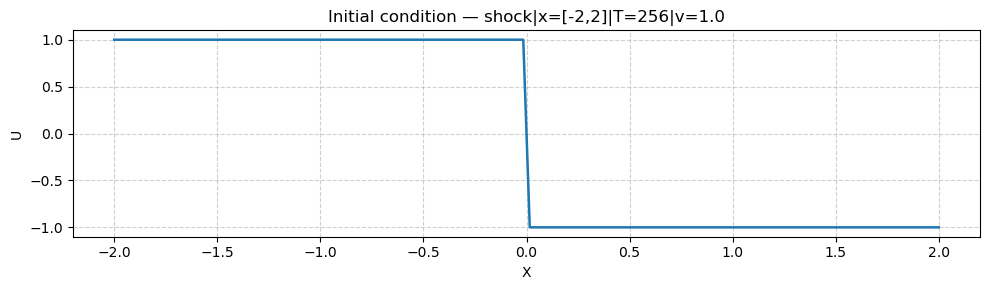

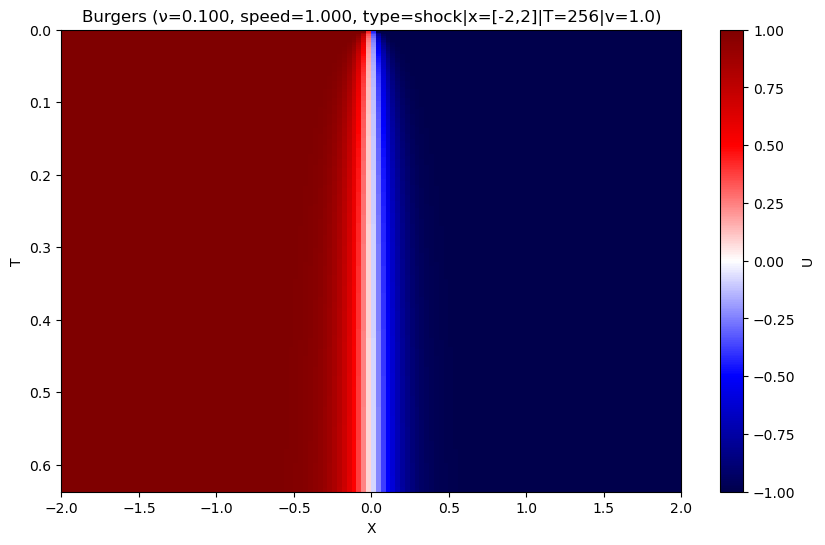

In [9]:
visualize_random_sample("generated_1d_burgers/train")